# Thompson Sampling Bayes Opt Moonshot 20uM

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../pinot/scripts/active/')

from thompson_sampling_plot import TSActivePlot

Using backend: pytorch


In [17]:
# Running functions
args = {
    'net': 'ExactGaussianProcessRegressor',
    'representation': 'GraphConv',
    'lr': 1e-4,
    'optimizer': 'Adam',
    'data': 'moonshot',
    'strategy': 'sequential',
    'acquisition': 'ExpectedImprovement',
    'num_thompson_samples': 1000,
    'num_samples': 1000,
    'q': 10,
    'device': 'cuda:0',
    'num_trials': 20,
    'num_rounds': 40,
    'num_epochs': 200,
    'index_provided': True,
}

from types import SimpleNamespace
args = SimpleNamespace(**args)

args.acquisition = 'ExpectedImprovement'

plot = TSActivePlot(

    # thompson sampling config
    num_thompson_samples=args.num_thompson_samples,
    
    # net config
    net=args.net,
    config=[32, 'tanh', 32, 'tanh', 32, 'tanh'],

    # optimizer config
    optimizer_type=args.optimizer,
    lr=args.lr,

    # experiment config
    data=args.data,
    acquisition=args.acquisition,
    num_samples=args.num_samples,
    q=args.q,

    # housekeeping
    device=args.device,
    num_trials=args.num_trials,
    num_rounds=args.num_rounds,
    num_epochs=args.num_epochs,
)

# run experiment
best_df, pro_ts_df, retro_ts_df = plot.generate()

# write to disk
best_df.to_csv(f'./out/best_{args.acquisition}_{args.q}.csv')
pro_ts_df.to_csv(f'./out/pro_{args.acquisition}_{args.q}.csv')
retro_ts_df.to_csv(f'./out/retro_{args.acquisition}_{args.q}.csv')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [18]:
def larger_font(ylabel):
    plt.xticks(size=20)
    plt.xlabel('Round', size=20)

    plt.yticks(size=20)
    plt.ylabel(ylabel, size=20)

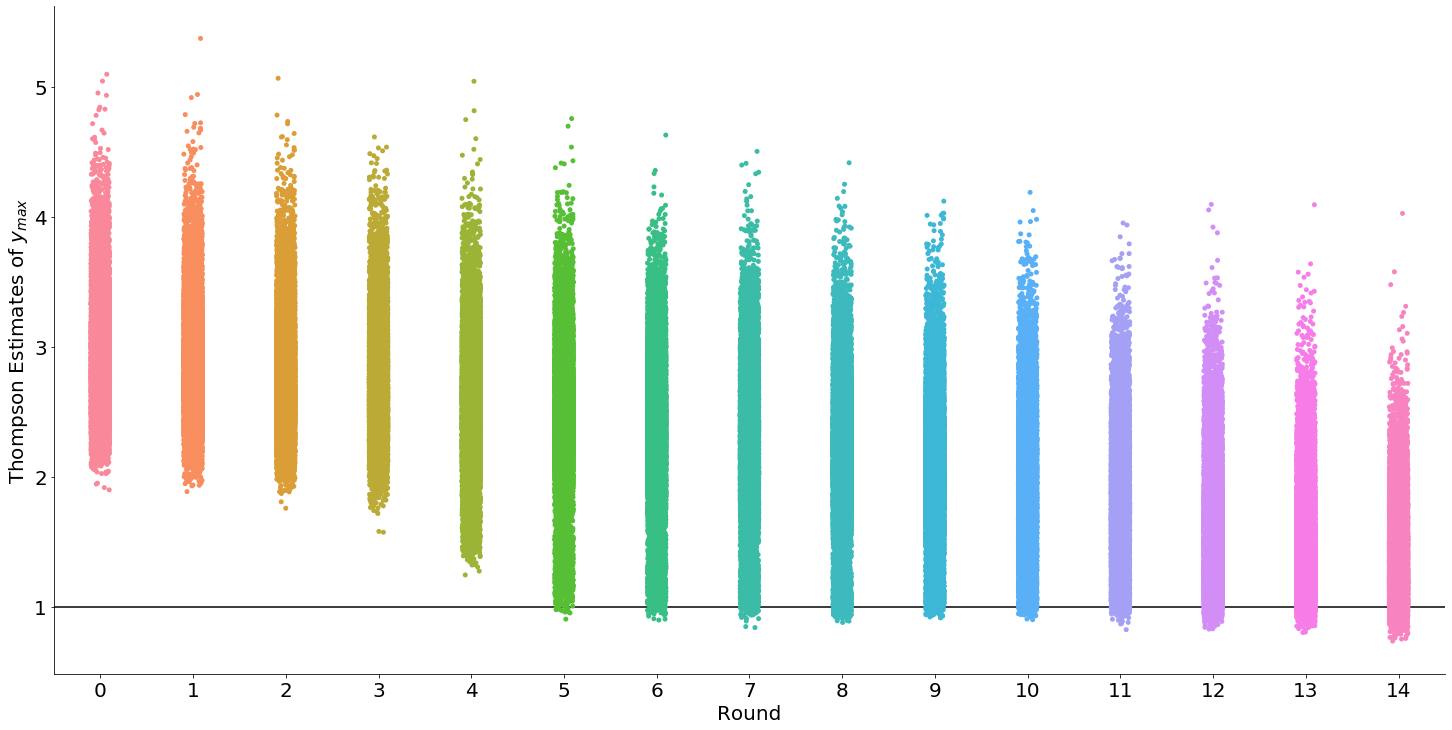

In [19]:
ds = plot.generate_data()
actual_best = ds[0][1].max().item()

import matplotlib.pyplot as plt
import seaborn as sns

sns.catplot(x='Round', y='Value',
    data=retro_ts_df,
#     kind='violin',
    height=10,
    aspect=2,
    split=True
)

larger_font('Thompson Estimates of $y_{max}$')
plt.axhline(actual_best, color='black')

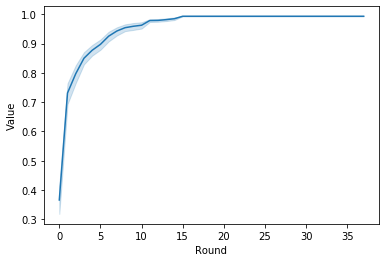

In [20]:
import seaborn as sns

sns.lineplot(x='Round', y='Value', data=best_df)

In [21]:
# ds = plot.generate_data()
# actual_max = ds[0][1].max().item()

import torch
import numpy as np
import pandas as pd
import seaborn as sns

improvement_list = []
for trial in pro_ts_df.Trial.unique():
    for round_ in pro_ts_df.Round.unique():
        round_values = pro_ts_df[pro_ts_df['Round'] == round_][pro_ts_df['Trial'] == trial]['Value']
        round_best = best_df[best_df['Round'] == round_][best_df['Trial'] == trial]['Value'].iloc[0]
        improvement_list.append({'Acquisition Function': 'ExpectedImprovement',
                                 'Trial': trial,
                                 'Round': round_,
                                 'ProbabilityImprovement': (round_values > round_best).mean(),
                                 'ExpectedImprovement': (np.maximum(round_values - round_best, 0)).mean()})
improvement_df = pd.DataFrame(improvement_list)

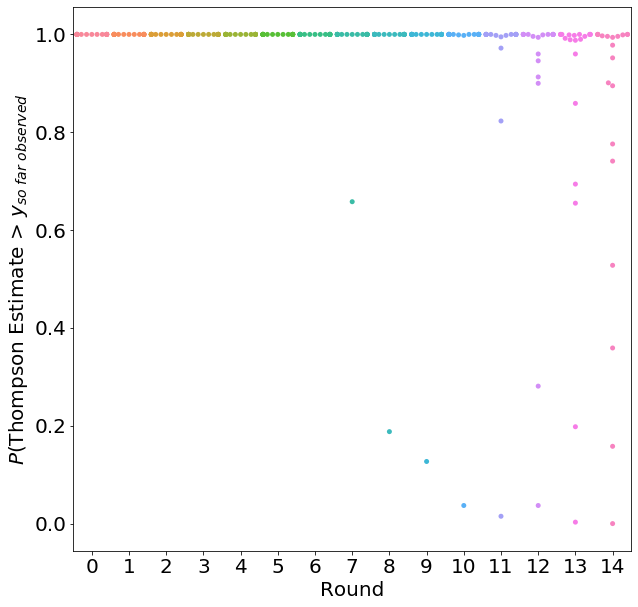

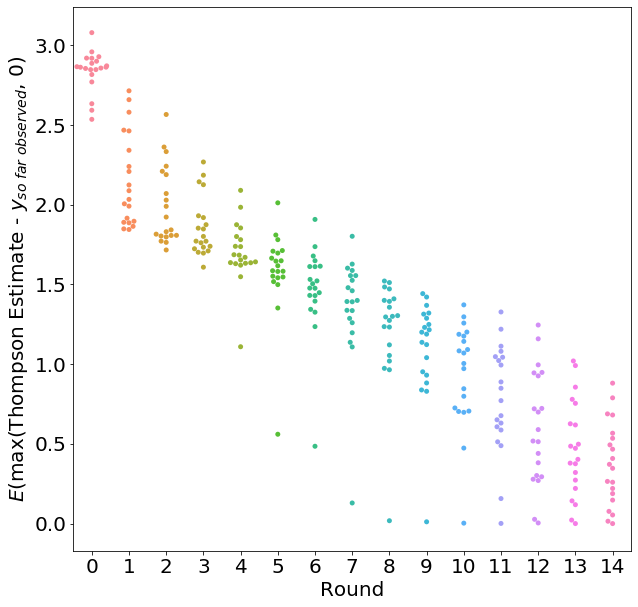

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(figsize=(10, 10))
sns.swarmplot(x='Round', y='ProbabilityImprovement', data=improvement_df, ax=ax)
larger_font('$P$(Thompson Estimate > $y_{so\ far\ observed}$')

fig, ax = plt.subplots(figsize=(10, 10))
sns.swarmplot(x='Round', y='ExpectedImprovement', data=improvement_df, ax=ax)
plt.ylabel('Thompson Estimates of $y_{max}$')
larger_font('$E$($\max$(Thompson Estimate - $y_{so\ far\ observed}$, 0)')